# Lending-Club-Loan-Data

This **Project** is [Dataquest's](https://www.dataquest.io/course/machine-learning-project) Monthly Challenge for the month of October, 2016.

In this challenge, we are to explore using [past loan data from Lending Club](https://www.lendingclub.com/info/download-data.action) to build models that can predict if a loan will be paid off on time or not.

## Approach :

We are looking at the problem from the **conservative investor's** standpoint -- we are more interested in a low **False Positive Rate(FPR)** than a high **True Positive Rate(TPR)**


## Goal:

Construct a machine learning model that achieves a **TPR greater than 50%** while maintaining a **FPR less than 7%**.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 5000)
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,12)

To start with, I will read into Pamdas the Lending Club loans data. This dataset contains **loans data from 2007-2011**.

**A quick comment about the loans data**:  This [Stanford University project report](http://cs229.stanford.edu/proj2015/199_report.pdf) mentions 'last_fico_range_high'(a column in the dataset) as the most predictive field of all the columns. However, the loans dataset that Lending Club makes available for downloads does not include some of this field. To get all the fields listed in their Data Dictionary, you may have to sign up.

In [2]:
# skip row 1 so pandas can parse the data properly.
loans_2007 = pd.read_csv('lending_club_loans.csv', skiprows=1, low_memory=False) 
half_count = len(loans_2007) / 2
loans_2007 = loans_2007.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values
loans_2007 = loans_2007.drop(['url','desc'],axis=1)      # Don't need these columns.


In [3]:


print(loans_2007.shape)
loans_2007.head()

(42538, 56)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0,Jan-1985,735,739,1,3,0,13648,83.7%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Sep-2016,744,740,0,1,INDIVIDUAL,0,0,0,0,0
1,1077430,1314167,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0,Apr-1999,740,744,5,3,0,1687,9.4%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2016,499,0,0,1,INDIVIDUAL,0,0,0,0,0
2,1077175,1313524,2400,2400,2400,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0,Nov-2001,735,739,2,2,0,2956,98.5%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Sep-2016,719,715,0,1,INDIVIDUAL,0,0,0,0,0
3,1076863,1277178,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0,Feb-1996,690,694,1,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,604,600,0,1,INDIVIDUAL,0,0,0,0,0
4,1075358,1311748,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0,Jan-1996,695,699,0,15,0,27783,53.9%,38,f,270.78,270.78,3784.490000,3784.49,2729.22,1055.27,0.00,0.00,0.00,Sep-2016,67.79,Sep-2016,694,690,0,1,INDIVIDUAL,0,0,0,0,0


## Data Dictionary from Lending Club

This data dictionary explains what each column in the loans dataset represents.

In [4]:
data_dictionary = pd.read_csv('LCDataDictionary.csv')
print(data_dictionary.shape[0])
data_dictionary.columns.tolist()

117


['LoanStatNew', 'Description']

In [5]:
data_dictionary.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


## Join the first row of loans_2007 and data_dictionary:
As mentioned on [Dataquest](https://www.dataquest.io/course/machine-learning-project), loans_2007 dataframe contains many columns(117), which can be cumbersome to try to explore all at once.

So I'll break up the columns into groups using the merged data_dictonary and first row of loans_2007 to understand what each column represent.

### Note:
    The intent of exploring the columns at this stage is to filter out all fields in the loans dataset that will not be available when we're using the model on future loans.
    
    Also, we want to discard any field which obviously has no effect on the target.

In [6]:
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name'})

loans_2007_dtypes = pd.DataFrame(loans_2007.dtypes,columns=['dtypes'])
loans_2007_dtypes = loans_2007_dtypes.reset_index()
loans_2007_dtypes['name'] = loans_2007_dtypes['index']
loans_2007_dtypes = loans_2007_dtypes[['name','dtypes']]

# the column, first_value, contains values of first row in loans_2007
loans_2007_dtypes['first value'] = loans_2007.loc[0].values
preview = loans_2007_dtypes.merge(data_dictionary, on='name',how='left')

### Please note:
     The name field in preview dataframe contains the names of the columns in loans_2007.
    

In [7]:
preview.head()

,name,dtypes,first value,Description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.


## FIRST GROUP OF COLUMNS:

In [8]:
preview[:25]

,name,dtypes,first value,Description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.
5,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,object,10.65%,Interest Rate on the loan
7,installment,float64,162.87,The monthly payment owed by the borrower if the loan originates.
8,grade,object,B,LC assigned loan grade
9,sub_grade,object,B2,LC assigned loan subgrade


In [9]:
drop_list = ['id','member_id','funded_amnt','funded_amnt_inv','grade','sub_grade','emp_title','issue_d']
loans_2007 = loans_2007.drop(drop_list,axis=1)
loans_2007.head(2)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000,36 months,10.65%,162.87,10+ years,RENT,24000,Verified,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0,Jan-1985,735,739,1,3,0,13648,83.7%,9,f,0,0,5863.155187,5833.84,5000.00,863.16,0,0.00,0.00,Jan-2015,171.62,Sep-2016,744,740,0,1,INDIVIDUAL,0,0,0,0,0
1,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,Source Verified,Charged Off,n,car,bike,309xx,GA,1.00,0,Apr-1999,740,744,5,3,0,1687,9.4%,4,f,0,0,1008.710000,1008.71,456.46,435.17,0,117.08,1.11,Apr-2013,119.66,Sep-2016,499,0,0,1,INDIVIDUAL,0,0,0,0,0


**Notice** I didn't drop 'zip_code' field though we did drop on [Dataquest](https://www.dataquest.io/course/machine-learning-project). I will explain later, and you'll see why we need it.

## SECOND GROUP OF COLUMNS:

In [10]:
preview[25:50]

,name,dtypes,first value,Description
25,fico_range_low,float64,735,The lower boundary range the borrower’s FICO at loan origination belongs to.
26,fico_range_high,float64,739,The upper boundary range the borrower’s FICO at loan origination belongs to.
27,inq_last_6mths,float64,1,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
28,open_acc,float64,3,The number of open credit lines in the borrower's credit file.
29,pub_rec,float64,0,Number of derogatory public records
30,revol_bal,float64,13648,Total credit revolving balance
31,revol_util,object,83.7%,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."
32,total_acc,float64,9,The total number of credit lines currently in the borrower's credit file
33,initial_list_status,object,f,"The initial listing status of the loan. Possible values are – W, F"
34,out_prncp,float64,0,Remaining outstanding principal for total amount funded


In [11]:
drop_cols = ['out_prncp','out_prncp_inv',
             'total_pymnt','total_pymnt_inv',
             'total_rec_prncp', 'fico_range_low',
             'total_rec_int','total_rec_late_fee',
             'recoveries','collection_recovery_fee',
             'last_pymnt_d','last_pymnt_amnt', 'last_fico_range_low']
loans_2007 = loans_2007.drop(drop_cols, axis=1)
loans_2007.head(2)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000,36 months,10.65%,162.87,10+ years,RENT,24000,Verified,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0,Jan-1985,739,1,3,0,13648,83.7%,9,f,Sep-2016,744,0,1,INDIVIDUAL,0,0,0,0,0
1,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,Source Verified,Charged Off,n,car,bike,309xx,GA,1.00,0,Apr-1999,744,5,3,0,1687,9.4%,4,f,Sep-2016,499,0,1,INDIVIDUAL,0,0,0,0,0


## THIRD GROUP OF COLUMNS:

In [12]:
preview[50:]

,name,dtypes,first value,Description
50,application_type,object,INDIVIDUAL,Indicates whether the loan is an individual application or a joint application with two co-borrowers
51,acc_now_delinq,float64,0,The number of accounts on which the borrower is now delinquent.
52,chargeoff_within_12_mths,float64,0,Number of charge-offs within 12 months
53,delinq_amnt,float64,0,The past-due amount owed for the accounts on which the borrower is now delinquent.
54,pub_rec_bankruptcies,float64,0,Number of public record bankruptcies
55,tax_liens,float64,0,Number of tax liens


In [13]:
# Nothing obvious to drop here

In [14]:
# Let's see number of columns we now have:
loans_2007.shape[1]

35

## TARGET COLUMN

I will use the **'loan_status'** field since it is the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. -[Dataquest](https://www.dataquest.io/course/machine-learning-project)

Let's **explore the different values in 'loan_status'** column:

In [15]:
loans_2007.loan_status.value_counts()

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64

There are 9 unique values

## CLASSIFICATION

The goal here is to build a machine learning model that will predict who will pay off loan on time and who wil not. This will help avoid investing on risky borrower.

On [Dataquest](https://www.dataquest.io/course/machine-learning-project), we classified "Fully Paid" as positive and "Charged Off" as negative. I want to extend the negative net to include 'Late (31 -120 days)' and 'Default'. 



In [16]:
mapping_dict = {'loan_status':{'Fully Paid':1,'Charged Off': 0,'Late (31-120 days)': 0,'Default': 0}}
loans_2007 = loans_2007.replace(mapping_dict)
loans_2007 = loans_2007[(loans_2007['loan_status'] == 1) | (loans_2007['loan_status'] == 0)]

loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000,36 months,10.65%,162.87,10+ years,RENT,24000,Verified,1,n,credit_card,Computer,860xx,AZ,27.65,0,Jan-1985,739,1,3,0,13648,83.7%,9,f,Sep-2016,744,0,1,INDIVIDUAL,0,0,0,0,0
1,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,Source Verified,0,n,car,bike,309xx,GA,1.00,0,Apr-1999,744,5,3,0,1687,9.4%,4,f,Sep-2016,499,0,1,INDIVIDUAL,0,0,0,0,0
2,2400,36 months,15.96%,84.33,10+ years,RENT,12252,Not Verified,1,n,small_business,real estate business,606xx,IL,8.72,0,Nov-2001,739,2,2,0,2956,98.5%,10,f,Sep-2016,719,0,1,INDIVIDUAL,0,0,0,0,0
3,10000,36 months,13.49%,339.31,10+ years,RENT,49200,Source Verified,1,n,other,personel,917xx,CA,20.00,0,Feb-1996,694,1,10,0,5598,21%,37,f,Apr-2016,604,0,1,INDIVIDUAL,0,0,0,0,0
5,5000,36 months,7.90%,156.46,3 years,RENT,36000,Source Verified,1,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,Nov-2004,734,3,9,0,7963,28.3%,12,f,Jan-2016,679,0,1,INDIVIDUAL,0,0,0,0,0


## Removing  Single  Value  Columns:

In [17]:
drop_columns = []

for col in loans_2007.columns:
    non_null = loans_2007[col].dropna()
    unique_non_null = non_null.unique()
    num_true_unique = len(unique_non_null)
    if num_true_unique < 2:
        drop_columns.append(col)
        
loans_2007 = loans_2007.drop(drop_columns, axis=1)
drop_columns

['initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [18]:
for col in loans_2007.columns:
    if (len(loans_2007[col].unique()) < 4):
        print(loans_2007[col].value_counts())
        print()

 36 months    29096
 60 months    10156
Name: term, dtype: int64

Not Verified       16846
Verified           12533
Source Verified     9873
Name: verification_status, dtype: int64

1    33586
0     5666
Name: loan_status, dtype: int64

n    39251
y        1
Name: pymnt_plan, dtype: int64



**Notice that** the pymnt_plan field has two unique values but the one value(y) has only 1 frequency and so it is safe to consider as a single value column.

In [19]:
print(loans_2007.shape[1])
loans_2007 = loans_2007.drop('pymnt_plan', axis=1)
loans_2007.shape[1]

27


26

# PREPARING  THE  FEATURES:



### Handling  Missing  Values

In [20]:
loans_2007.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
title                    10
zip_code                  0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
fico_range_high           0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               50
total_acc                 0
last_credit_pull_d        2
last_fico_range_high      0
pub_rec_bankruptcies    697
dtype: int64

In [21]:
loans_2007 = loans_2007.drop(['pub_rec_bankruptcies'], axis=1)


In [22]:
print(loans_2007.dtypes)
loans_2007.head(2)

loan_amnt               float64
term                     object
int_rate                 object
installment             float64
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
title                    object
zip_code                 object
addr_state               object
dti                     float64
delinq_2yrs             float64
earliest_cr_line         object
fico_range_high         float64
inq_last_6mths          float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util               object
total_acc               float64
last_credit_pull_d       object
last_fico_range_high    float64
dtype: object


,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high
0,5000,36 months,10.65%,162.87,10+ years,RENT,24000,Verified,1,credit_card,Computer,860xx,AZ,27.65,0,Jan-1985,739,1,3,0,13648,83.7%,9,Sep-2016,744
1,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,Source Verified,0,car,bike,309xx,GA,1.00,0,Apr-1999,744,5,3,0,1687,9.4%,4,Sep-2016,499




**Notice** these columns, 'int_rate' and 'revol_util' represent numeric values but are in text forms.
They need to be converted into float:

In [23]:
for col in ['int_rate','revol_util']:
    loans_2007[col] = loans_2007[col].str.rstrip('%').astype('float')

## TEXT COLUMNS

In [24]:
object_columns_df = loans_2007.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

term                     36 months
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
loan_status                      1
purpose                credit_card
title                     Computer
zip_code                     860xx
addr_state                      AZ
earliest_cr_line          Jan-1985
last_credit_pull_d        Sep-2016
Name: 0, dtype: object


## Categorical  Columns

Let's explore the unique value counts of the columns that seem to contain categorical values

In [25]:
cols = ['home_ownership','verification_status','emp_length','term','addr_state']

for col in cols:
    print(loans_2007[col].value_counts())
    print()

RENT        18721
MORTGAGE    17402
OWN          3028
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

Not Verified       16846
Verified           12533
Source Verified     9873
Name: verification_status, dtype: int64

10+ years    8723
< 1 year     4557
2 years      4351
3 years      4054
4 years      3395
5 years      3250
1 year       3216
6 years      2202
7 years      1742
8 years      1459
9 years      1246
n/a          1057
Name: emp_length, dtype: int64

 36 months    29096
 60 months    10156
Name: term, dtype: int64

CA    7032
NY    3762
FL    2834
TX    2700
NJ    1831
IL    1514
PA    1499
VA    1389
GA    1381
MA    1323
OH    1203
MD    1041
AZ     867
WA     831
CO     778
NC     773
CT     738
MI     718
MO     678
MN     611
NV     489
SC     469
WI     448
OR     442
AL     442
LA     432
KY     319
OK     295
KS     265
UT     255
AR     242
DC     213
RI     197
NM     187
WV     174
HI     171
NH     169
DE     114
MT      84
WY      83
AK  

In [26]:
for name in ['purpose','title']:
    print(loans_2007[name].value_counts())
    print()

debt_consolidation    18376
credit_card            5079
other                  3938
home_improvement       2951
major_purchase         2184
small_business         1797
car                    1536
wedding                 941
medical                 690
moving                  582
vacation                378
house                   372
educational             325
renewable_energy        103
Name: purpose, dtype: int64

Debt Consolidation                          2145
Debt Consolidation Loan                     1671
Personal Loan                                651
Consolidation                                503
debt consolidation                           495
Credit Card Consolidation                    354
Home Improvement                             350
Debt consolidation                           331
Small Business Loan                          318
Credit Card Loan                             310
Personal                                     306
Consolidation Loan                      

In [27]:
mapping_dict = {
    'emp_length':{
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
        'n/a': 0
    }
}

loans_2007 = loans_2007.drop(['last_credit_pull_d','addr_state','title','earliest_cr_line'], axis=1)
    
loans_2007 = loans_2007.replace(mapping_dict)
loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high
0,5000,36 months,10.65,162.87,10,RENT,24000,Verified,1,credit_card,860xx,27.65,0,739,1,3,0,13648,83.7,9,744
1,2500,60 months,15.27,59.83,0,RENT,30000,Source Verified,0,car,309xx,1.00,0,744,5,3,0,1687,9.4,4,499
2,2400,36 months,15.96,84.33,10,RENT,12252,Not Verified,1,small_business,606xx,8.72,0,739,2,2,0,2956,98.5,10,719
3,10000,36 months,13.49,339.31,10,RENT,49200,Source Verified,1,other,917xx,20.00,0,694,1,10,0,5598,21.0,37,604
5,5000,36 months,7.90,156.46,3,RENT,36000,Source Verified,1,wedding,852xx,11.20,0,734,3,9,0,7963,28.3,12,679


## Dummy  Variables

In [28]:
cat_columns = ['home_ownership','verification_status','purpose','term']
dummy_df = pd.get_dummies(loans_2007[cat_columns])
loans_2007 = pd.concat([loans_2007, dummy_df], axis=1)
loans_2007 = loans_2007.drop(cat_columns, axis=1)
loans_2007.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000,10.65,162.87,10,24000,1,860xx,27.65,0,739,1,3,0,13648,83.7,9,744,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2500,15.27,59.83,0,30000,0,309xx,1.00,0,744,5,3,0,1687,9.4,4,499,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2400,15.96,84.33,10,12252,1,606xx,8.72,0,739,2,2,0,2956,98.5,10,719,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,10000,13.49,339.31,10,49200,1,917xx,20.00,0,694,1,10,0,5598,21.0,37,604,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,5000,7.90,156.46,3,36000,1,852xx,11.20,0,734,3,9,0,7963,28.3,12,679,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [29]:
loans_2007['zip_code'].unique()

array(['860xx', '309xx', '606xx', '917xx', '852xx', '280xx', '900xx',
       '958xx', '774xx', '853xx', '913xx', '245xx', '951xx', '641xx',
       '921xx', '067xx', '890xx', '770xx', '335xx', '799xx', '605xx',
       '103xx', '150xx', '326xx', '564xx', '141xx', '080xx', '974xx',
       '934xx', '405xx', '946xx', '445xx', '850xx', '292xx', '088xx',
       '180xx', '029xx', '700xx', '010xx', '441xx', '104xx', '061xx',
       '616xx', '947xx', '914xx', '765xx', '980xx', '017xx', '972xx',
       '752xx', '787xx', '077xx', '540xx', '225xx', '440xx', '437xx',
       '559xx', '912xx', '325xx', '300xx', '923xx', '352xx', '013xx',
       '146xx', '074xx', '786xx', '937xx', '331xx', '115xx', '191xx',
       '114xx', '908xx', '902xx', '750xx', '950xx', '329xx', '226xx',
       '992xx', '614xx', '672xx', '083xx', '100xx', '926xx', '931xx',
       '712xx', '060xx', '707xx', '342xx', '604xx', '895xx', '430xx',
       '919xx', '996xx', '891xx', '935xx', '801xx', '928xx', '233xx',
       '927xx', '970

In [30]:
loans_2007['zip_code'] = loans_2007['zip_code'].str.rstrip('x')
loans_2007['zip_code'].head()

0    860
1    309
2    606
3    917
5    852
Name: zip_code, dtype: object

In [31]:
loans_2007.to_csv('loans_2007.csv', index=False)

In [32]:
filtered_loans = pd.read_csv('loans_2007.csv',low_memory=False)
filtered_loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000,10.65,162.87,10,24000,1,860,27.65,0,739,1,3,0,13648,83.7,9,744,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2500,15.27,59.83,0,30000,0,309,1.00,0,744,5,3,0,1687,9.4,4,499,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2400,15.96,84.33,10,12252,1,606,8.72,0,739,2,2,0,2956,98.5,10,719,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,10000,13.49,339.31,10,49200,1,917,20.00,0,694,1,10,0,5598,21.0,37,604,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,5000,7.90,156.46,3,36000,1,852,11.20,0,734,3,9,0,7963,28.3,12,679,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [33]:
def zip_formatted(row):
    if len(str(row)) == 1:
        row = str(row)+ '00'
    elif len(str(row)) == 2:
        row = str(row)+ '0'
    return int(row)

In [34]:
filtered_loans['zip_code'] = filtered_loans['zip_code'].apply(zip_formatted)

In [35]:
filtered_loans['zip_code'].unique()

array([860, 309, 606, 917, 852, 280, 900, 958, 774, 853, 913, 245, 951,
       641, 921, 670, 890, 770, 335, 799, 605, 103, 150, 326, 564, 141,
       800, 974, 934, 405, 946, 445, 850, 292, 880, 180, 290, 700, 100,
       441, 104, 610, 616, 947, 914, 765, 980, 170, 972, 752, 787, 540,
       225, 440, 437, 559, 912, 325, 300, 923, 352, 130, 146, 740, 786,
       937, 331, 115, 191, 114, 908, 902, 750, 950, 329, 226, 992, 614,
       672, 830, 926, 931, 712, 600, 707, 342, 604, 895, 430, 919, 996,
       891, 935, 801, 928, 233, 927, 970, 211, 303, 194, 263, 403, 301,
       553, 993, 312, 432, 602, 216, 151, 971, 305, 334, 500, 129, 925,
       483, 760, 961, 200, 981, 330, 601, 117, 630, 920, 543, 775, 570,
       380, 221, 985, 113, 275, 236, 148, 450, 532, 729, 321, 959, 941,
       955, 217, 660, 620, 193, 857, 306, 271, 142, 956, 983, 945, 109,
       112, 802, 187, 435, 488, 287, 705, 592, 318, 549, 212, 347, 274,
       265, 785, 270, 813, 260, 201, 349, 322, 124, 940, 967, 11

In [36]:
filtered_loans.isnull().sum()

loan_amnt                               0
int_rate                                0
installment                             0
emp_length                              0
annual_inc                              0
loan_status                             0
zip_code                                0
dti                                     0
delinq_2yrs                             0
fico_range_high                         0
inq_last_6mths                          0
open_acc                                0
pub_rec                                 0
revol_bal                               0
revol_util                             50
total_acc                               0
last_fico_range_high                    0
home_ownership_MORTGAGE                 0
home_ownership_NONE                     0
home_ownership_OTHER                    0
home_ownership_OWN                      0
home_ownership_RENT                     0
verification_status_Not Verified        0
verification_status_Source Verifie

In [37]:
filtered_loans = filtered_loans.dropna()
print(filtered_loans.dtypes.value_counts())
print()
filtered_loans.isnull().sum()

float64    38
int64       3
dtype: int64



loan_amnt                              0
int_rate                               0
installment                            0
emp_length                             0
annual_inc                             0
loan_status                            0
zip_code                               0
dti                                    0
delinq_2yrs                            0
fico_range_high                        0
inq_last_6mths                         0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc                              0
last_fico_range_high                   0
home_ownership_MORTGAGE                0
home_ownership_NONE                    0
home_ownership_OTHER                   0
home_ownership_OWN                     0
home_ownership_RENT                    0
verification_status_Not Verified       0
verification_status_Source Verified    0
verification_sta

In [38]:
filtered_loans.to_csv('filtered_loans.csv',index=False)

# MAKING PREDICTIONS

**Now, the reason for zip_code inclusion in the prediction features**: I'm borrowing an idea from the [Stanford project report](http://cs229.stanford.edu/proj2015/199_report.pdf) - they reported using the zip_code to join this census data ["Median House- hold Income and Mean Household Income [2006-2010]"](http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/). Here's a direct quote from the report explaining the use of census data:
    "... research like "The sensitivity of the loss given default rate to systematic risk" [4] has shown the link- age between default rate and macroeconomic factors, so we have decided to add in census data, with info like regional median income, to train our models on a more holistic set of features."
    
I will not join the census data to our loans data, instead will use just the zip_code to achieve the same results.

Also, I will start off with just the columns we used on Dataquest, which exclude 'last_fico_range_high' I mentioned earlier and the 'zip_code'. And, later include these fields.



In [39]:
loans = pd.read_csv('filtered_loans.csv',low_memory=False)
loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000,10.65,162.87,10,24000,1,860,27.65,0,739,1,3,0,13648,83.7,9,744,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2500,15.27,59.83,0,30000,0,309,1.00,0,744,5,3,0,1687,9.4,4,499,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2400,15.96,84.33,10,12252,1,606,8.72,0,739,2,2,0,2956,98.5,10,719,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,10000,13.49,339.31,10,49200,1,917,20.00,0,694,1,10,0,5598,21.0,37,604,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,5000,7.90,156.46,3,36000,1,852,11.20,0,734,3,9,0,7963,28.3,12,679,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [40]:
loans['zip_code'].unique()

array([860, 309, 606, 917, 852, 280, 900, 958, 774, 853, 913, 245, 951,
       641, 921, 670, 890, 770, 335, 799, 605, 103, 150, 326, 564, 141,
       800, 974, 934, 405, 946, 445, 850, 292, 880, 180, 290, 700, 100,
       441, 104, 610, 616, 947, 914, 765, 980, 170, 972, 752, 787, 540,
       225, 440, 437, 559, 912, 325, 300, 923, 352, 130, 146, 740, 786,
       937, 331, 115, 191, 114, 908, 902, 750, 950, 329, 226, 992, 614,
       672, 830, 926, 931, 712, 600, 707, 342, 604, 895, 430, 919, 996,
       891, 935, 801, 928, 233, 927, 970, 211, 303, 194, 263, 403, 301,
       553, 993, 312, 432, 602, 216, 151, 971, 305, 334, 500, 129, 925,
       483, 760, 961, 200, 981, 330, 601, 117, 630, 920, 543, 775, 570,
       380, 221, 985, 113, 275, 236, 148, 450, 532, 729, 321, 959, 941,
       955, 217, 660, 620, 193, 857, 306, 271, 142, 956, 983, 945, 109,
       112, 802, 187, 435, 488, 287, 705, 592, 318, 549, 212, 347, 274,
       265, 785, 270, 813, 260, 201, 349, 322, 124, 940, 967, 11

**Let's make sure** the loans DataFrame contains the right data types(numerics), and also has no null value before applying machine learning algorithms:

In [41]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39202 entries, 0 to 39201
Data columns (total 41 columns):
loan_amnt                              39202 non-null float64
int_rate                               39202 non-null float64
installment                            39202 non-null float64
emp_length                             39202 non-null int64
annual_inc                             39202 non-null float64
loan_status                            39202 non-null int64
zip_code                               39202 non-null int64
dti                                    39202 non-null float64
delinq_2yrs                            39202 non-null float64
fico_range_high                        39202 non-null float64
inq_last_6mths                         39202 non-null float64
open_acc                               39202 non-null float64
pub_rec                                39202 non-null float64
revol_bal                              39202 non-null float64
revol_util                   

**Let's also** observe the frequency distribution of the unique values in the target column to help decide on the choice of **error metric**

In [42]:
loans['loan_status'].value_counts() / loans.shape[0]

1    0.855875
0    0.144125
Name: loan_status, dtype: float64

The value_counts shows a **significant class imbalance** in the target column - more than 85% of the loans were paid on time.

## Picking  An  Error  Metric And Handling The Class Imbalance


Since the **main goal** here is to construct a machine learning model that achieves a **TPR greater than 50%** while maintaining a **FPR less than 7%** ,it would be a terrible mistake to use just **accuracy** to measure model performance especially given such a high positive rate in the target column. Therefore, I'll not use **accuracy**   istead use metrics that tell us the number of **false positives** and **false negatives** -[Dataquest](https://www.dataquest.io/course/machine-learning-project).

In [43]:
def compute_metrics(predictions):
    
    predictions = pd.Series(predictions)
    # False positives
    fp_filter = (predictions == 1) & (loans['loan_status'] == 0)
    fp = len(predictions[fp_filter])
    
    # True positives
    tp_filter = (predictions == 1) & (loans['loan_status'] == 1)
    tp = len(predictions[tp_filter])
    
    # False negatives
    fn_filter = (predictions == 0) & (loans['loan_status'] == 1)
    fn = len(predictions[fn_filter])
    
    # True negatives
    tn_filter = (predictions == 0)& (loans['loan_status'] == 0)
    tn = len(predictions[tn_filter])
    
    # Rates
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    print(tpr * 100)
    print(fpr * 100)
    print()
    
    print('Other Mesurements:')
    
    
    sp = tn / (tn + fp)
    sty = tp / (tp + fn)
    G_mean = np.sqrt(sp * sty)
    prcn = tp / (tp + fp)
    acc = (tn + tp) / features.shape[0]
    method_dict = {'specificity': '{:.2f}'.format(sp*100), 
               'sensitivity': '{:.2f}'.format(sty*100), 
               'G-mean': '{:.2f}'.format(G_mean*100),
               'precision': '{:.2f}'.format(prcn*100), 
               'accuracy': '{:.2f}'.format(acc*100),
               'False Positive Rate': '{:.2f}'.format(fpr*100)
              }
    return pd.DataFrame(method_dict,index=['values'])

## Predictions without these columns:
    1. last_fico_range_high
    2. zip_code

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict, KFold

scaler = StandardScaler()

In [45]:
x_cols = loans.columns
features_cols = x_cols.drop(['loan_status','last_fico_range_high','zip_code']) # Dropping last_fico_range_high field
features = loans[features_cols]
target = loans['loan_status']

## Logistic Regression:

In [46]:


lr = LogisticRegression()
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features,target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

99.9850977587029
99.929203539823

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,99.93,2.66,85.58,85.59,99.99,0.07


We can see from the table this model achieves 85.47 accuracy which misleadingly because while it does good job of predicting 99.98%(sensitivity) of the 1s, it's able to predict just 0.05%(specificity) of the 0s. This explains why **accuracy** cannot be relied on in this problem. Hence, we need to tell the Classifier to **penalize misclassifications of the less prevalent class more than the other class** -['Dataquest'](https://www.dataquest.io/course/machine-learning-project)

## Manual Penalties

In [47]:


penalty = {
    0: 13,
    1: 1
}

lr = LogisticRegression(class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features,target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics


23.76311397234144
7.451327433628318

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,7.45,46.90,33.68,94.98,23.76,92.55


As you can see when I dropped the 'last_fico_range_high' and 'zip_code' fields the figures I got are approximately what we got on Dataquest - in the last mission.

Now, let's include thses fields and then move on:

## Predictions with these columns:
    1. last_fico_range_high
    2. zip_code

In [48]:
x_cols = loans.columns
features_cols = x_cols.drop(['loan_status'])
features = loans[features_cols]
target = loans['loan_status']

In [49]:
penalty = {
    0: 12,
    1: 1
}

lr = LogisticRegression(class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features,target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

72.63054363376253
8.176991150442477

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,8.18,81.66,75.40,98.14,72.63,91.82


**Notice** the significant increase in performance with regard to our **tpr** and **fpr** when I included the 'last_fico_range_high', in particular.
This should be expected since a borrower's recent credit score encompass all the other fields with exception of 'purpose' field which is rendered as dummy variables. I think the same idea can be extended to the 'zip_code' field. The project report mentioned above suggest a link between macroeconomic factors such as regional median income, mean income, population, and the likelihood of a borrower defaulting on a loan. If this assumption is plausible then, just as a credit score can hold many other factors, so can zip code represents all macroeconomic indexes of an area.
By way, I downloaded the ["Median House- hold Income and Mean Household Income [2006-2010]"](http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/), experimented with it and came to this conclusion. 

## Debugging  Algorithms  With Grid Search , Feature Selection  And Learning Curves

Now, let's  see **how performance can be improved**. This book, [Python Data Science Essentials](https://www.amazon.com/Python-Data-Science-Essentials-fundamentals/dp/1785280422), proved to be resourceful at this stage.

## Determine The Best Parameters  With GridSearchCV:

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV

In [51]:
penalty = {
    0: 14,
    1: 1
}

pipe = make_pipeline(LogisticRegression(class_weight=penalty))
C_range = 10.**np.arange(-2, 3)
penalty_options = ['l1','l2']
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc')
grid.fit(features, target)
grid.best_score_

0.9026214252717244

In [52]:
grid.best_params_   # Print best parameters for the logistic model

{'logisticregression__C': 100.0, 'logisticregression__penalty': 'l1'}

## Determine Feature Importance:

In [53]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

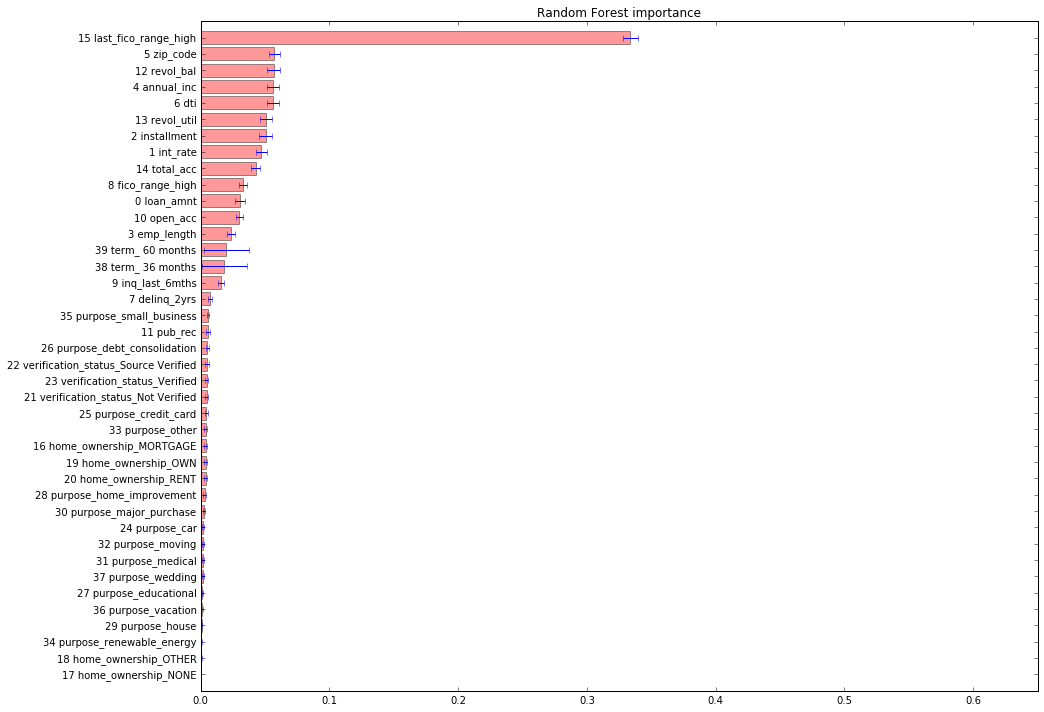

In [54]:
RF = RandomForestRegressor(n_estimators=100, random_state=1).fit(features,target)



feature_names = np.array([' '.join([str(b), a]) for a,b in
zip(features.columns,range(len(features.columns)))])


importance = np.mean([tree.feature_importances_ for tree in RF.estimators_],axis=0)
std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importance)
range_ = range(len(importance))
plt.figure()
plt.title("Random Forest importance")

plt.barh(range_,importance[indices], color="r", xerr=std[indices], alpha=0.4, align="center")

plt.yticks(range(len(importance)), feature_names[indices])
plt.ylim([-1, len(importance)])
plt.xlim([0.0, 0.65])
plt.show()

The plot indicates 'last_fico_range_high' as the most predictive field followed by the 'zip_code' field.

Note: some field appeared as important but may have a negative effect on the model's specificity and sensitivity. Let's check some of these features relationship with the prediction results - is it positive or negative.

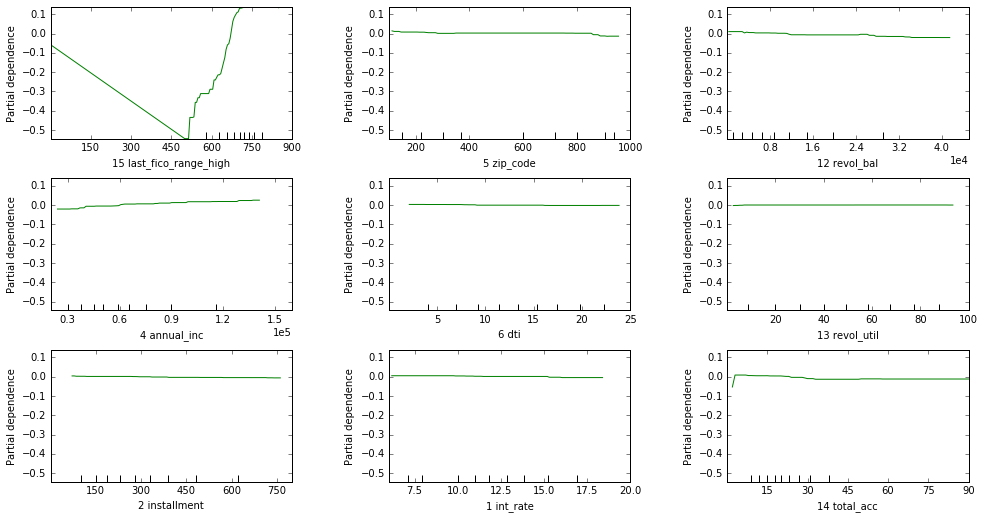

In [55]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
GBM = GradientBoostingRegressor(n_estimators=100,random_state=1).fit(features, target)
feature = [15,5,12,4,6,13,2,1,14]
fig, axis = plot_partial_dependence(GBM, features, feature,feature_names=feature_names)

With these revelations, let's back to the models:

In [56]:
features = loans[['last_fico_range_high','total_acc','annual_inc','loan_amnt','zip_code']]
target = loans['loan_status']

In [57]:
features.columns.tolist()

['last_fico_range_high', 'total_acc', 'annual_inc', 'loan_amnt', 'zip_code']

## Logistic  Regression

In [58]:
penalty = {
    0: 12,
    1: 1
}

lr = LogisticRegression(C=1.0,penalty='l1',class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features,target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

73.00906056270863
6.920353982300885

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,6.92,82.44,75.90,98.43,73.01,93.08


### Let's experiment with just 'last_fico_range_high':

In [59]:
penalty = {
    0: 12,
    1: 1
}

lr = LogisticRegression(C=1.0,penalty='l1',class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features[['last_fico_range_high']],target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

70.48164043872198
5.68141592920354

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,5.68,81.53,73.92,98.66,70.48,94.32


## Random Forest
**Random Forest** does well with just **last_fico_range_high** field.

In [60]:
penalty = {
    0: 12,
    1: 1
}

rf = RandomForestClassifier(random_state=1,class_weight=penalty)



kf = KFold(features.shape[0],random_state=1)
predictions = cross_val_predict(rf, features[['last_fico_range_high']],target,cv=kf)


# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

71.34597043395327
6.389380530973451

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,6.39,81.72,74.55,98.51,71.35,93.61


## Logistic  Regression With Higher Manual Penalty:

In [61]:
penalty = {
    0: 13,
    1: 1
}

lr = LogisticRegression(C=1.0,penalty='l1',class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

X = scaler.fit_transform(features)

predictions = cross_val_predict(lr,X,target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

71.629113018598
6.353982300884955

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,6.35,81.90,74.80,98.53,71.63,93.65


In [62]:
penalty = {
    0: 15,
    1: 1
}

lr = LogisticRegression(C=1.0,penalty='l1',class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features,target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

69.20004768717214
5.3097345132743365

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,5.31,80.95,72.87,98.72,69.20,94.69


##  The Logistic Model  Learning Curve:

In [63]:
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import SGDClassifier

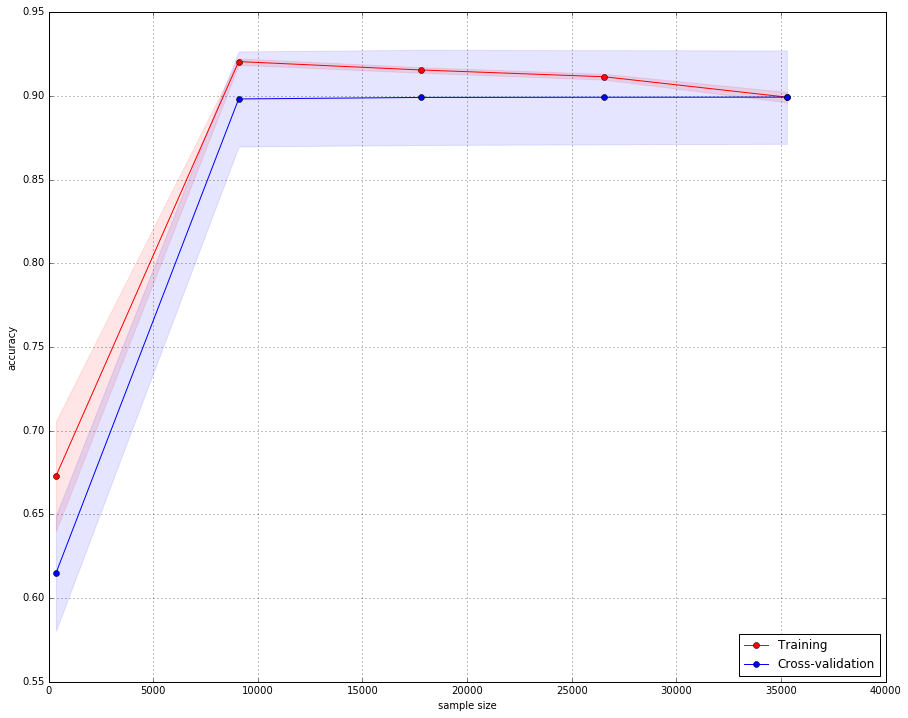

In [64]:
penalty = {
    0: 12,
    1: 1
}
lr = LogisticRegression(C=0.01,penalty='l1',class_weight=penalty)


train_size,train_scores,test_scores = learning_curve(lr,features,target,train_sizes=np.linspace(.01,1.0,5),cv=10,
                                                    scoring='roc_auc',exploit_incremental_learning=False,n_jobs=-1)
mean_train = np.mean(train_scores,axis=1)
upper_train = np.clip(mean_train + np.std(train_scores,axis=1),0,1)
lower_train = np.clip(mean_train - np.std(train_scores,axis=1),0,1)
mean_test = np.mean(test_scores,axis=1)
upper_test = np.clip(mean_test + np.std(test_scores,axis=1),0,1)
lower_test = np.clip(mean_test - np.std(test_scores,axis=1),0,1)
plt.plot(train_size,mean_train,'ro-',label='Training')
plt.fill_between(train_size,upper_train,lower_train,alpha=0.1,color='r')
plt.plot(train_size,mean_test,'bo-', label='Cross-validation')
plt.fill_between(train_size, upper_test, lower_test, alpha=0.1,color='b')
plt.grid()
plt.xlabel('sample size') # adds label to x axis
plt.ylabel('accuracy') # adds label to y axis
plt.legend(loc='lower right', numpoints= 1)
plt.show()

The model has a problem of **high Bias**. The **training score** and **test score** merged when sample size is greater than 3500. 

**Once again, working with just 'last_fico_range_high' field**:

In [65]:
penalty = {
    0: 12,
    1: 1
}

lr = LogisticRegression(C=1.0,penalty='l1',class_weight=penalty)
kf = KFold(features.shape[0],random_state=1)

predictions = cross_val_predict(lr,features[['last_fico_range_high']],target,cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

70.48164043872198
5.68141592920354

Other Mesurements:


,False Positive Rate,G-mean,accuracy,precision,sensitivity,specificity
values,5.68,81.53,73.92,98.66,70.48,94.32
